# BGSE Text Mining Homework 1
### Laura Roman, Veronika Kyuchukova and Euan Dowers
#### April 21, 2017

## Exercise 1

In [7]:
import nltk
import string
import pandas as pd
import numpy as np
import pickle
import os
import matplotlib
from matplotlib import pyplot as plt
from nltk import tokenize
from nltk.corpus import stopwords
from nltk.stem import porter
from numpy.linalg import svd
from scipy.misc import logsumexp
from nltk.tokenize import RegexpTokenizer

In [8]:
'''
QUESTION 1
'''

# Read in data
# documents defined at the paragraph level
data = pd.read_table("speech_data_extend.txt",encoding="utf-8")
speeches = data['speech']


In [9]:
def my_tokeniser(speeches):
    # Tokenize speeches
    tokenizer = RegexpTokenizer(r'\w+')
    sp_tkn = [tokenizer.tokenize(speech) for speech in speeches]
    return sp_tkn

def remove_nonalph(sp_tkn):
    # Remove non-alphabetic tokens
    for i in range(len(sp_tkn)):
        sp_tkn[i] = [j for j in sp_tkn[i] if j[0] in set(string.ascii_letters)]
    return sp_tkn

def stopword_del(sp_tkn):
    # Remove stopwords
    stop = set(stopwords.words('english'))
    for i in range(len(sp_tkn)):
        sp_tkn[i] = [j.lower() for j in sp_tkn[i] if j.lower() not in stop]
    return sp_tkn

def my_stem(sp_tkn):
    # Stem words in documents
    stemmer = porter.PorterStemmer()
    stemmed = [[stemmer.stem(word) for word in doc] for doc in sp_tkn]
    return stemmed

def remove_zerolen_strings(stemmed, data):
    idx = [i for i in range(len(stemmed)) if len(stemmed[i]) == 0]
    stemmed = [i for i in stemmed if len(i) > 0]
    data = data.drop(data.index[idx])
    #data = data.reset_index()
    return [stemmed, data]

def data_processing(data):
    '''
    Put together all steps in data processing. NOTE data must have column 'speech'
    '''
    speeches = data.speech
    sp_tkn = my_tokeniser(speeches)
    sp_tkn = remove_nonalph(sp_tkn)
    sp_tkn = stopword_del(sp_tkn)
    stemmed = my_stem(sp_tkn)
    stemmed, data = remove_zerolen_strings(stemmed, data)
    return [stemmed, data]

In [12]:
# CALCULATING TF-IDF SCORES

def get_vocab(stemmed_data):
    # extracts corpus vocabulary from list of documents
    vocab = list(set().union(*stemmed_data))
    return vocab

def doc_count(stemmed,vocab):
    # counts how many documents each word appears in
    df = dict(zip(vocab,[0]*len(vocab)))
    for i in range(len(stemmed)):
        words = set(stemmed[i])
        for j in words:
            df[j] = df[j]+1
    return df

def make_IDF(stemmed,vocab):
    # Calculates IDF factor for each word in vocabulary
    D   = len(stemmed)
    n   = len(get_vocab(stemmed))
    df  = doc_count(stemmed,vocab)
    IDF = [np.log(D/d) for d in df.values()]
    IDF_dict = dict(zip(vocab,IDF))
    return IDF_dict

def make_count(stemmed):
    vocab = get_vocab(stemmed)
    D = len(stemmed)
    n = len(vocab)
    idx = dict(zip(vocab,range(len(vocab))))
    count_matrix = np.ndarray(shape=(D,n))

    for i in range(len(stemmed)):
        for j in set(stemmed[i]):
            count_matrix[i,idx[j]] = stemmed[i].count(j)
    return count_matrix

def corpus_tf(stemmed):
    # Calculate corpus-level TF-IDF scores
    count_matrix = make_count(stemmed)
    tf = 1 +  np.log(np.sum(count_matrix, axis = 0))
    return tf

def corpus_tf_idf(stemmed):
    # Calculate corpus-level TF-IDF scores
    count_matrix = make_count(stemmed)
    vocab = get_vocab(stemmed)
    idf = list(make_IDF(stemmed, vocab).values())
    tf = 1 +  np.log(np.sum(count_matrix, axis = 0))
    tf_idf = tf * idf
    return tf_idf

def custom_stopword_del(stemmed, our_stopwords):
    for i in range(len(stemmed)):
        stemmed[i] = [j.lower() for j in stemmed[i] if j.lower() not in our_stopwords]
    return stemmed

def make_TF_IDF(stemmed):
    # Calculates TF-IDF matrix
    vocab = get_vocab(stemmed)
    D = len(stemmed)
    idx = dict(zip(vocab,range(len(vocab))))
    IDF_dict = make_IDF(stemmed,vocab)
    tf_idf = np.ndarray(shape=(D,len(vocab)))

    for i in range(len(stemmed)):
        for j in set(stemmed[i]):
            tf_idf[i,idx[j]] = stemmed[i].count(j)*IDF_dict[j]
    return tf_idf

In [11]:
# PROCESS THE DATA
stemmed, processed_data = data_processing(data)

#tf scores
vocab = get_vocab(stemmed)
tf_scores = corpus_tf(stemmed)

sort_tf = sorted(tf_scores,reverse=True)
ind_tf = sorted(range(len(tf_scores)), key=lambda k: tf_scores[k],reverse=True)
vocab_s = [vocab[i] for i in ind_tf]

term_sorttf = pd.DataFrame(
    {'term': vocab_s,
    'tf': sort_tf
    })

#tf-idf scores
tf_idf_scores = corpus_tf_idf(stemmed)

sort_tfidf = sorted(tf_idf_scores,reverse=True)
ind_tfidf = sorted(range(len(tf_idf_scores)), key=lambda k: tf_idf_scores[k],reverse=True)
vocab_sidf = [vocab[i] for i in ind_tfidf]
#sorted tf_idf

term_sortfidf = pd.DataFrame(
    {'term': vocab_sidf,
    'tf-idf': sort_tfidf
    })

our_stopwords = set(vocab_sidf[0:3000])

stemmed = custom_stopword_del(stemmed, our_stopwords)
stemmed, processed_data = remove_zerolen_strings(stemmed, processed_data)

In [6]:
print(stemmed[0])
print(processed_data.speech[1])

['repres']
I embrace with great satisfaction the opportunity which now presents itself of congratulating you on the present favorable prospects of our public affairs. The recent accession of the important state of North Carolina to the Constitution of the United States (of which official information has been received), the rising credit and respectability of our country, the general and increasing good will toward the government of the Union, and the concord, peace, and plenty with which we are blessed are circumstances auspicious in an eminent degree to our national prosperity.


You can see from the example above the effect of our custom stopword removal, with words such as 'house' and 'senate' obviously context-specific. 


## Exercise 2

#### Exercise 2 a)
We have come up with 7 dictionaries (topics) of interest which are lists of positive, negative, uncertainty, passive, ethics, politics, economy and military words. 

We load these lists of words, stem them and clean them by getting rid of ambiguous words. That is, words that appear in more than one dictionary. 

In [ ]:
%run dict_cleaning.py

In [21]:
#we can access these diccionaries with the variables
positive_dict
negative_dict
uncert_dict
passive_dict
politic_dict
econ_dict
military


1024

#### Exercise 2 b)
In order to provide a quantitative representation of each document, we can construct a documents-topics matrix where each row is a document and each of the seven columns represents a dictionary or topic. Followingly, the (i,j) matrix entry represents the number of words are classified as topic j in the document i.

In [13]:

def count_on_dict(sentiment_dictionary, words):
    """
    description: calculate counts of a word list based on a dictionary
    """
    recognized_word_count = 0

    words_list = []
    for word in words:
        if word in sentiment_dictionary:
            recognized_word_count += 1
            words_list.append(word)

    return recognized_word_count, words_list

def docs_dict_matrix(stem,positive_dict,negative_dict,ethic_dict,politic_dict,econ_dict,military_dict,uncert_dict,passive_dict ):
    '''
    description: computes docs-topics matrix with data arranged by year or by docs
    '''    
    counts = np.ndarray(shape=(len(stem),8))
    for j in range(len(stem)):
        words = []
        words = stem[j]
        counts[j,0] = count_on_dict(positive_dict,words)[0]
        counts[j,1] = count_on_dict(negative_dict,words)[0]
        counts[j,2] = count_on_dict(uncert_dict,words)[0]
        counts[j,3] = count_on_dict(passive_dict,words)[0]
        counts[j,4] = count_on_dict(ethic_dict,words)[0]
        counts[j,5] = count_on_dict(politic_dict,words)[0]
        counts[j,6] = count_on_dict(econ_dict,words)[0]
        counts[j,7] = count_on_dict(military_dict,words)[0]
        #pos_words = calculate_sentiment_for_word_list(positive_dict,words)[1] # classif words
    
    counts = pd.DataFrame(counts, columns=['pos', 'neg', 'unc', 'passive', 'ethic', 'polit', 'econ', 'milit'])
    counts['total'] = counts.sum(axis=1)
    return counts

And we obtaint the documents-topics matrix (dtm):

In [ ]:
dtm = docs_dict_matrix(stemmed,positive_dict,negative_dict,ethic_dict,politic_dict,econ_dict,military_dict,uncert_dict,passive_dict )
dtm.shape
dtm

More illustrative is to show the percentage of the different topics across all documents (whole corpus).  

In [24]:
sum_odocs = dtm.sum(axis=0)
perc = np.ndarray(shape=(8,))
for i in range(8):
    perc[i]=100*sum_odocs[i]/sum_odocs[8]
perc = pd.DataFrame(perc)
perc.columns = ['%']
perc.index =    ['positive', 'negative', 'uncertainty', 'passive', 'ethic', 'politics', 'economy', 'military']
perc.sort_values(by='%', ascending=0)

,%
economy,32.466973
passive,19.548670
positive,16.266055
politics,15.689663
negative,6.828436
military,4.242648
ethic,2.516131
uncertainty,2.441424


On the other hand, we are interested in studying the yearly evolution of the speeches content instead of that for each 
one of the paragraphs (or documents). 

In [26]:
#yearly data processing
data_by_years= pd.DataFrame(processed_data)
data_by_years = data_by_years.groupby('year', sort=False, as_index=True)['speech'].apply(' '.join)
data_by_years = data_by_years.reset_index()
stemmed_y, processed_data_y = data_processing(data_by_years)


And we obtain the year-topics matrix:

In [27]:
yt = docs_dict_matrix(stemmed_y,positive_dict,negative_dict,ethic_dict,politic_dict,econ_dict,military_dict,uncert_dict,passive_dict )
yt['year'] =data_by_years['year']
yt.shape

(224, 10)

That can aswell be expressed by percentages:

In [30]:
ytp=yt
ytp['pos']=100*ytp['pos']/ytp['total']; ytp['neg']=100*ytp['neg']/ytp['total']
ytp['unc']=100*ytp['unc']/ytp['total']; ytp['passive']=100*ytp['passive']/ytp['total']
ytp['ethic']=100*ytp['ethic']/ytp['total']; ytp['polit']=100*ytp['polit']/ytp['total']
ytp['econ']=100*ytp['econ']/ytp['total']; ytp['milit']=100*ytp['milit']/ytp['total']
ytp['total']=100; ytp['year'] =data_by_years['year']
ytp

,pos,neg,unc,passive,ethic,polit,econ,milit,total,year
0,24.114441,8.310627,2.316076,22.070845,1.771117,12.397820,26.158038,2.861035,100,1790
1,23.145401,9.643917,3.264095,21.810089,2.670623,13.501484,23.887240,2.077151,100,1791
2,20.176991,12.743363,2.300885,24.601770,1.415929,13.628319,21.769912,3.362832,100,1792
3,17.931034,12.068966,2.241379,20.172414,2.758621,14.655172,25.517241,4.655172,100,1793
4,21.638142,13.814181,3.178484,17.359413,2.811736,16.014670,19.559902,5.623472,100,1794
5,24.098361,11.147541,1.967213,22.622951,3.934426,12.131148,20.327869,3.770492,100,1795
6,23.122066,7.863850,2.582160,19.835681,2.230047,12.676056,26.173709,5.516432,100,1796
7,20.097245,11.993517,2.269044,19.935170,2.917342,13.452188,27.228525,2.106969,100,1797
8,22.550544,11.508554,2.643857,20.217729,2.332815,12.130638,25.349922,3.265941,100,1798
9,19.913420,11.038961,2.380952,17.316017,3.246753,14.718615,28.354978,3.030303,100,1799


We now wish to understand this data by visualizing it:

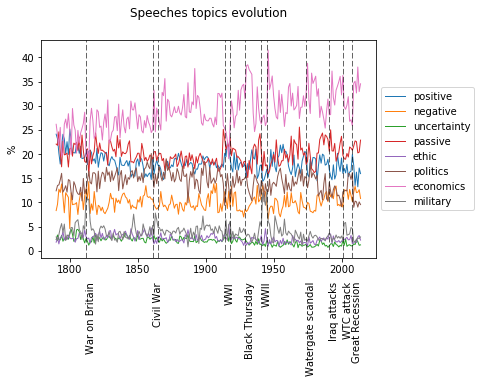

In [50]:
us_dates = [1812,1861,1865,1914,1918,1929,1941,1945, 1974,1991,2001,2008]
us_dates_exp = ['War on Britain','Civil War',
                '',
                'WWI','', 'Black Thursday','WWII','',
                'Watergate scandal','Iraq attacks','WTC attack', 'Great Recession']

X = ytp['year']
Y1 = ytp['pos'];Y2= ytp['neg'];Y3 = ytp['unc'];Y4= ytp['passive']
Y5 = ytp['ethic'];Y6= ytp['polit'];Y7 = ytp['econ']; Y8= ytp['milit']
plt.plot(X, Y1,   lw = 1., label = 'positive')
plt.plot(X, Y2, lw = 1., label = 'negative')
plt.plot(X, Y3, lw = 1., label = 'uncertainty')
plt.plot(X, Y4, lw = 1., label = 'passive')
plt.plot(X, Y5, lw = 1., label = 'ethic')
plt.plot(X, Y6,  lw = 1., label = 'politics')
plt.plot(X, Y7,  lw = 1., label = 'economics')
plt.plot(X, Y8,  lw = 1., label = 'military')
for i in range(len(us_dates)):
    plt.axvline(us_dates[i],linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-8,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

Notice we have marked important historical US dates that hopefully will somewhat be related with the content of the yearly president speeches. In order to see more clearly what is going on with the topic time series, we will disagreggate the previous plot for 4 different time periods: 

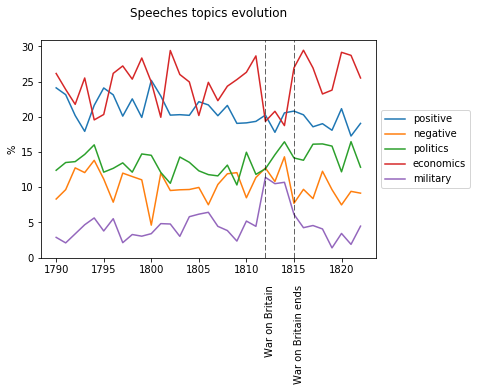

In [40]:
us_dates = [1812, 1815]
us_dates_exp = ['War on Britain', 'War on Britain ends']
plt.plot(X[0:33], Y1[0:33],   lw = 1.5, label = 'positive')
plt.plot(X[0:33], Y2[0:33], lw = 1.5, label = 'negative')
#plt.plot(X[0:33], Y3[0:33], lw = 1.5, label = 'uncertainty')
#plt.plot(X[0:33], Y4[0:33], lw = 1.5, label = 'passive')
#plt.plot(X[0:33], Y5[0:33], lw = 1.5, label = 'ethics')
plt.plot(X[0:33], Y6[0:33],  lw = 1.5, label = 'politics')
plt.plot(X[0:33], Y7[0:33],  lw = 1.5, label = 'economics')
plt.plot(X[0:33], Y8[0:33],  lw = 1.5, label = 'military')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-5,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/1820s.png', bbox_inches='tight')

plt.show()

The US-Britain war (aka The War of 1812) was a military conflict that lasted from June 1812 to February 1815, fought between the United States of America and the United Kingdom, its North American colonies, and its Native American allies. 
We can see that during this period yearly speeches were more military oriented and less economics oriented, which really makes if you're the president of a country on war. 

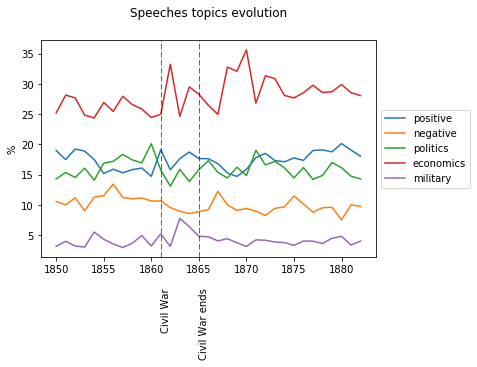

In [43]:
us_dates = [1861,1865]
us_dates_exp = ['Civil War','Civil War ends']
plt.plot(X[60:93], Y1[60:93],   lw = 1.5, label = 'positive')
plt.plot(X[60:93], Y2[60:93], lw = 1.5, label = 'negative')
#plt.plot(X[60:93], Y3[60:93], lw = 1.5, label = 'uncertainty')
#plt.plot(X[60:93], Y4[60:93], lw = 1.5, label = 'passive')
#plt.plot(X[60:93], Y5[60:93], lw = 1.5, label = 'ethics')
plt.plot(X[60:93], Y6[60:93],  lw = 1.5, label = 'politics')
plt.plot(X[60:93], Y7[60:93],  lw = 1.5, label = 'economics')
plt.plot(X[60:93], Y8[60:93],  lw = 1.5, label = 'military')
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-5,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/1850s.png', bbox_inches='tight')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))


plt.show()

The American Civil War was an internal conflict fought in the United States (U.S.) from 1861 to 1865. The Union (i.e., The United States) faced secessionists in eleven Southern states grouped together as the Confederate States of America. The Union won the war, which remains the bloodiest in U.S. history.

Again, speeches are more militar oriented and economic terms are very dominant in the speeches, experiencing an increase of frequency during this period. The American Civil War had a very strong economic background as Southern whites believed that the emancipation of slaves would destroy the South's economy, due to the large amount of capital invested in slaves and fears of integrating the ex-slave black population, p.e. 

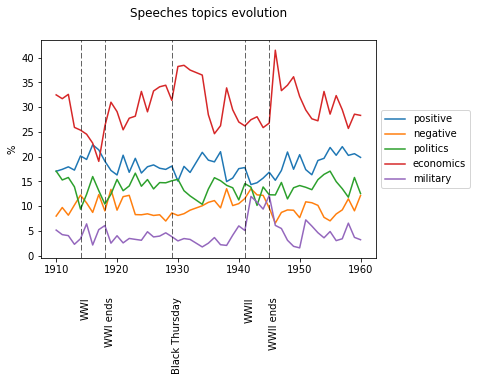

In [44]:
us_dates = [ 1914,1918,1929,1941,1945]
us_dates_exp = ['WWI','WWI ends', 'Black Thursday','WWII','WWII ends']
plt.plot(X[120:170], Y1[120:170],   lw = 1.5, label = 'positive')
plt.plot(X[120:170], Y2[120:170], lw = 1.5, label = 'negative')
#plt.plot(X[120:170], Y3[120:170], lw = 1.5, label = 'uncertainty')
#plt.plot(X[120:170], Y4[120:170], lw = 1.5, label = 'passive')
#plt.plot(X[120:170], Y5[120:170], lw = 1.5, label = 'ethics')
plt.plot(X[120:170], Y6[120:170],  lw = 1.5, label = 'politics')
plt.plot(X[120:170], Y7[120:170],  lw = 1.5, label = 'economics')
plt.plot(X[120:170], Y8[120:170], lw = 1.5, label = 'military')
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-10,us_dates_exp[i],rotation=90)
plt.ylabel('%')
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/interest1900s.png', bbox_inches='tight')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))

plt.show()

During the first half of the 90's speechecs became more and more economy-related. It is interesting to compare the composition of speeches in the First World War (1914-1918) with that in the Second World War (1941-1945). 
The United States declared war on Germany on April 6, 1917, during World War I. The U.S. was an independent power and did not officially join the Allies. It closely cooperated with them militarily but acted alone in diplomacy. This explains why, while a war was taking place, presidential speeches didn't become more military nor economically oriented but remained mainly as positive speeches. 

On the other hand, in the Second World War patriotism became the central theme of advertising throughout the war, as large scale campaigns were launched to sell war bonds, promote efficiency in factories, reduce ugly rumors, and maintain civilian morale. The media cooperated and the federal government presented the official view of the war. This can be clearly seen as speeches were mainly about military and during war were increasingly more positive and less negative to give courage to the population.

The Black Tuesday (or The Wall Street Crash), began on October 24 1929 and was the most devastating stock market crash in the history of the United States, and signaled the beginning of the 12-year Great Depression that affected all Western industrialized countries. Compromising the following years presidential speeches to be even more economics-related than before. 

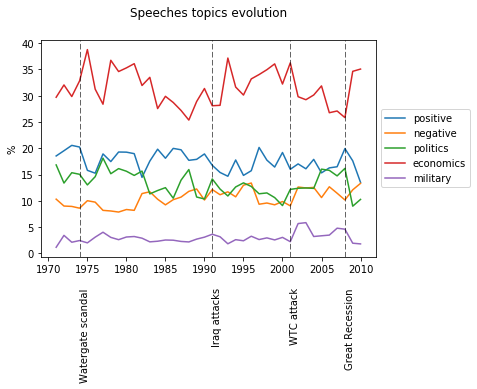

In [49]:
us_dates = [ 1974,1991,2001,2008]
us_dates_exp = ['Watergate scandal','Iraq attacks','WTC attack', 'Great Recession']
plt.plot(X[180:220], Y1[180:220],   lw = 1.5, label = 'positive')
plt.plot(X[180:220], Y2[180:220], lw = 1.5, label = 'negative')
#plt.plot(X[180:220], Y3[180:220], lw = 1.5, label = 'uncertainty')
#plt.plot(X[180:220], Y4[180:220], lw = 1.5, label = 'passive')
#plt.plot(X[180:220], Y5[180:220], lw = 1.5, label = 'ethics')
plt.plot(X[180:220], Y6[180:220],  lw = 1.5, label = 'politics')
plt.plot(X[180:220], Y7[180:220],  lw = 1.5, label = 'economics')
plt.plot(X[180:220], Y8[180:220], lw = 1.5, label = 'military')
plt.legend(loc='center left', bbox_to_anchor=(1, 0.5))
for i in range(len(us_dates)):
    plt.axvline(us_dates[i], linestyle="dashed", color="black", lw=0.6)
    plt.text(us_dates[i],-8,us_dates_exp[i],rotation=90)
plt.title('Speeches topics evolution', y=1.08)
plt.savefig('./figures/2000s.png', bbox_inches='tight')
plt.ylabel('%')


plt.show()


The immediate years after the unfortunate events that took place during 1970-2010, Watergate scandal, Iraq attacks, World Trade Center attach, and the Great Recession; speeches became less positive and more negative. 

After Iraq attacks, speeches didn't become more military oriented but less, as it was an offensive strategy of war on another land. However, after the World Trade Center attack where US was the victim speeches became very military-oriented as this attach would lead into more war-strategies.

Again, after the Great Economic Recession speeches became more economic-oriented, less positive and more negative.

#### Exercise 2. c)
We are interested in finding some correlations between relevant US time series and the addresses. We will study two different time series: unemployment in the US and US average interest rate in the period (1948 - 2010). We expect to find that unemployment is positively correlated with uncertainty in this period, whereas average interest rate should be negatively correlated. 

In [51]:
from scipy.stats.stats import pearsonr

uncert= ytp[ytp.year >= 1948].unc.reset_index(drop=True).values; posit= ytp[ytp.year >= 1948].pos.reset_index(drop=True).values
negat= ytp[ytp.year >= 1948].neg.reset_index(drop=True).values; passive= ytp[ytp.year >= 1948].passive.reset_index(drop=True).values
econ= ytp[ytp.year >= 1948].econ.reset_index(drop=True).values; polit= ytp[ytp.year >= 1948].polit.reset_index(drop=True).values
milit= ytp[ytp.year >= 1948].milit.reset_index(drop=True).values


In [56]:
''' unemployment'''
file = pd.read_table("./timeseries/annual_unemployment.txt",header=None)
unempl = pd.DataFrame(file[1]); unempl = unempl[1].values

corr_unempl = [pearsonr(unempl, uncert), pearsonr(unempl, posit),pearsonr(unempl, negat),
                pearsonr(unempl, passive) ,pearsonr(unempl, econ),pearsonr(unempl, polit),pearsonr(unempl, milit) ] 
corr_unempl = pd.DataFrame(corr_unempl)
corr_unempl[2] = ['uncertainty', 'positive', 'negative', 'passive', 'economy', 'politics', 'military']; corr_unempl.columns = ('unempl corr', 'p-val','topic')
corr_unempl

,unempl corr,p-val,topic
0,0.118086,0.341239,uncertainty
1,-0.305309,0.011994,positive
2,0.317184,0.008915,negative
3,0.042920,0.730195,passive
4,0.294265,0.015644,economy
5,-0.286794,0.018623,politics
6,-0.332435,0.005986,military


Correlation between unemployment and uncertainty in the US during 1948-2010 is positive as we expected, however from the p-value we see that such correlation is not significant. Also we have computed the correlation with the other topics. 

In [57]:

'''inflation rate'''
file2 = pd.read_table("./timeseries/inflation_rate.txt",header=None)
infl = file2[file2[0]>=1948].reset_index(drop=True); infl = pd.DataFrame(infl[1]); infl = infl[1].values

corr_infl = [pearsonr(infl, uncert), pearsonr(infl, posit),pearsonr(infl, negat),
                pearsonr(infl, passive) ,pearsonr(infl, econ),pearsonr(infl, polit),pearsonr(infl, milit) ] 
corr_infl = pd.DataFrame(corr_infl)
corr_infl[2] = ['uncertainty', 'positive', 'negative', 'passive', 'economy', 'politics', 'military']; corr_infl.columns = ('infl corr', 'p-val','topic')
corr_infl

,infl corr,p-val,topic
0,-0.209711,0.088521,uncertainty
1,0.100105,0.420243,positive
2,-0.259302,0.034097,negative
3,-0.301843,0.013050,passive
4,0.159761,0.196563,economy
5,0.291809,0.016575,politics
6,-0.041886,0.736458,military


Correlation between inflation rate and uncertainty is negative as expected, and such correlation is significant. 

#### Exercise 2.d)
Using the same dictionaries we now want to compute the content of each yearly-document using term weighting instead of document-topic counts as we have already done. Because in Exercise 2.b) we didn't show top topic document rankings, we will do now for both dt scoring and tf-idf scoring, comparing the results and checking that top year-docs obained with this method coincides with what we obtained in the code previously shown. 

In [58]:
from collections import OrderedDict

def ranking(stemmed,data,dictionary, use_tf_idf, n):  
    vocab = get_vocab(stemmed)
    dt_matrix = make_count(stemmed)
    tfidf_matrix = make_TF_IDF(stemmed)

    if (use_tf_idf):
        dtm = tfidf_matrix
    else:
        dtm = dt_matrix

    dict_tokens_set = set(item for item in dictionary)
    intersection = list(set(dict_tokens_set) & set(vocab))
    vec_positions = [int(token in intersection) for token in vocab] 

    sums = np.zeros(len(dtm))
    for j in range(len(dtm)):
        sums[j] = sum([a * b for a, b in zip(dtm[j], vec_positions)])

        order = sorted(range(len(sums)), key = lambda k: sums[k], reverse=True)
    ordered_year_data_n = [None] * len(dtm)
    ordered_sums = np.zeros(len(dtm))

    counter = 0        
    for num in order:
        ordered_year_data_n[counter] = data.year[num]
        ordered_sums[counter] = sums[num]
        counter += 1

    return list((ordered_year_data_n[0:n], ordered_sums[0:n]))

 

We proceed to rank top 10 year for each topic/dictionary and for both scoring methods, dt and tf-idf.

In [59]:
n_rank = 10

# dt score
pos_sorted_years,pos_tf_score = ranking(stemmed_y, processed_data_y, positive_dict, False, n_rank) 
neg_sorted_years,neg_tf_score = ranking(stemmed_y, processed_data_y, negative_dict, False, n_rank) 
et_sorted_years,et_tf_score = ranking(stemmed_y, processed_data_y, ethic_dict, False, n_rank) 
pol_sorted_years,pol_tf_score = ranking(stemmed_y, processed_data_y, politic_dict, False, n_rank) 
ec_sorted_years,ec_tf_score = ranking(stemmed_y, processed_data_y, econ_dict, False, n_rank) 
mil_sorted_years,mil_tf_score = ranking(stemmed_y, processed_data_y, military_dict, False, n_rank) 
unc_sorted_years,unc_tf_score = ranking(stemmed_y, processed_data_y, uncert_dict, False, n_rank) 
pas_sorted_years,pas_tf_score = ranking(stemmed_y, processed_data_y, passive_dict, False, n_rank) 

DT_score = pd.DataFrame(OrderedDict({'year_p':pos_sorted_years, 'positive':pos_tf_score,
'year_n':neg_sorted_years ,'negative':neg_tf_score, 'y_et':et_sorted_years, 'ethic':et_tf_score, 
'y_pol':pol_sorted_years, 'politics':pol_tf_score, 'y_ec':ec_sorted_years, 'econ':ec_tf_score, 
'y_mil':mil_sorted_years, 'military':mil_tf_score, 'y_u':unc_sorted_years, 'uncertainty':unc_tf_score, 'y_pas':pas_sorted_years, 'passive':pas_tf_score} ))



In [63]:
pd.DataFrame({'year_p':pos_sorted_years, 'positive':pos_tf_score})

,positive,year_p
0,2442.0,1981
1,2398.0,1980
2,1748.0,1974
3,1626.0,1979
4,1404.0,1907
5,1349.0,1910
6,1347.0,1946
7,1325.0,1912
8,1301.0,1905
9,1249.0,1899


In [66]:
n_rank = 10

# tf-idf score
ipos_sorted_years,ipos_tf_score = ranking(stemmed_y, processed_data_y, positive_dict,True,n_rank) 
ineg_sorted_years,ineg_tf_score = ranking(stemmed_y, processed_data_y, negative_dict,True,n_rank) 
iet_sorted_years,iet_tf_score = ranking(stemmed_y, processed_data_y, ethic_dict,True,n_rank) 
ipol_sorted_years,ipol_tf_score = ranking(stemmed_y, processed_data_y, politic_dict,True,n_rank) 
iec_sorted_years,iec_tf_score = ranking(stemmed_y, processed_data_y, econ_dict,True,n_rank) 
imil_sorted_years,imil_tf_score = ranking(stemmed_y, processed_data_y, military_dict,True,n_rank) 
iunc_sorted_years,iunc_tf_score = ranking(stemmed_y, processed_data_y, uncert_dict,True,n_rank) 
ipas_sorted_years,ipas_tf_score = ranking(stemmed_y, processed_data_y, passive_dict,True,n_rank) 

TFIDF_score = pd.DataFrame(OrderedDict({'year_p':ipos_sorted_years, 'positive':ipos_tf_score,
'year_n':ineg_sorted_years ,'negative':ineg_tf_score, 'y_et':iet_sorted_years, 'ethic':iet_tf_score, 
'y_pol':ipol_sorted_years, 'politics':ipol_tf_score, 'y_ec':iec_sorted_years, 'econ':iec_tf_score, 
'y_mil':imil_sorted_years, 'military':imil_tf_score, 'y_u':iunc_sorted_years, 'uncertainty':iunc_tf_score, 'y_pas':ipas_sorted_years, 'passive':ipas_tf_score} ))


In [67]:
TFIDF_score

,year_p,positive,year_n,negative,y_et,ethic,y_pol,politics,y_ec,econ,y_mil,military,y_u,uncertainty,y_pas,passive
0,1981,1646.784016,1906,1107.545465,1906,210.240296,1981,1018.653545,1981,2271.962061,1898,210.606513,1981,111.606366,1981,996.367428
1,1980,1544.877419,1981,1098.738570,1905,159.235868,1980,919.565728,1980,2148.226404,1907,202.176363,1885,90.193562,1980,809.391088
2,1974,1101.825908,1980,1083.950102,1907,127.414275,1979,624.787998,1946,1765.532708,1945,192.984237,1906,85.245132,1907,765.066632
3,1979,1049.190779,1905,991.814948,1901,106.601700,1974,565.418010,1979,1401.701115,1910,176.327168,1946,82.219584,1906,748.173839
4,1907,905.311984,1908,983.892426,1904,100.333008,1899,537.018647,1974,1317.323903,1946,165.151034,1979,78.768595,1905,742.063930
5,1899,880.667910,1907,960.270787,1908,90.994754,1953,519.904613,1910,1165.804877,1980,160.569663,1974,76.854885,1974,676.002347
6,1906,837.749459,1901,700.696384,1885,89.162020,1910,513.204972,1911,1028.381833,1981,159.531853,1911,76.209012,1910,647.022448
7,1898,835.531294,1895,698.909895,1845,86.434765,1906,476.952611,1978,1001.291408,1912,130.871468,1905,72.987201,1946,641.672934
8,1912,829.607863,1974,697.782377,1911,84.057455,1912,465.049529,1912,936.159795,1908,127.916085,1839,69.401624,1912,638.780902
9,1910,818.788928,1904,689.092251,1830,83.977221,1900,464.628884,1907,922.781162,1905,127.598967,1907,68.884695,1898,634.473692


## Exercise 3

In [10]:
import sklearn
import scipy
from sklearn.metrics.pairwise import cosine_similarity
from scipy.sparse.linalg import svds

def make_TF_IDF(stemmed):
    # Calculates TF-IDF matrix
    vocab = get_vocab(stemmed)
    D = len(stemmed)
    idx = dict(zip(vocab,range(len(vocab))))
    IDF_dict = make_IDF(stemmed,vocab)
    tf_idf = np.ndarray(shape=(D,len(vocab)))

    for i in range(len(stemmed)):
        for j in set(stemmed[i]):
            tf_idf[i,idx[j]] = stemmed[i].count(j)*IDF_dict[j]
    return tf_idf

In [11]:
# Comparison of parties post 1860

# First collect names and assign parties to all presidents after first Republican president elected
pres    = sorted(list ( set(data.loc[data.year > 1860].president)))
party   = ['rep']*3 + ['dem']*3 + ['rep']*8 + ['dem']*3 + ['rep']*3 + ['dem']*1 + ['rep']*2 + ['dem'] + ['rep'] + ['dem']*2

pres_party = dict(zip(pres, party))

data_post1860 = processed_data.loc[processed_data.year > 1860]
parties = [pres_party[i] for i in data_post1860.president]
data_post1860 = data_post1860.assign(party=parties)

stemmed_post1860, processed_post1860 = data_processing(data_post1860)
stemmed_post1860 = custom_stopword_del(stemmed_post1860, our_stopwords)
stemmed_post1860, processed_post1860 = remove_zerolen_strings(stemmed_post1860, processed_post1860)

In [12]:
parties_post1860 = [i for i in processed_post1860.party]
dem_idx = [i for i in range(len(parties_post1860)) if parties_post1860[i] == 'dem']
rep_idx = [i for i in range(len(parties_post1860)) if parties_post1860[i] == 'rep']

In [13]:
tf_idf_post1860 = make_TF_IDF(stemmed_post1860)

In [14]:
cos_sim = cosine_similarity(tf_idf_post1860)

In [15]:
similarity_within_dem = cos_sim[dem_idx,:][:,dem_idx]
similarity_within_rep = cos_sim[rep_idx,:][:,rep_idx]
similarity_between_parties = cos_sim[dem_idx,:][:,rep_idx]

In [16]:
print(np.mean(similarity_within_dem))
print(np.mean(similarity_within_rep))
print(np.mean(similarity_between_parties))

0.0131152125584
0.0123853337248
0.0116981829146


Interestingly, this analysis gives that on average Democrats are more similar to Republicans than they are to other Democrats. This suggests that Democrats are more varied in their use of language than Republicans. 

This could perhaps be a result of the changing ideology of both parties over 150 years, from being the party of slavery to the party that elected the first black President. Perhaps it would make sense to analyse the difference between Republicans and Democrats from the mid 1960s onwards when the migration of Southern Democrats to the Republican party represented a change in ideology for both parties. 

In [17]:
# Data Processing
data_post1965 = processed_data.loc[processed_data.year >= 1965]
data_post1965 = data_post1965.reset_index(drop=True)
parties = [pres_party[i] for i in data_post1965.president]
data_post1965 = data_post1965.assign(party=parties)

stemmed_post1965, processed_post1965 = data_processing(data_post1965)

stemmed_post1965 = custom_stopword_del(stemmed_post1965, our_stopwords)
stemmed_post1965, processed_post1965 = remove_zerolen_strings(stemmed_post1965, processed_post1965)

parties_post1965 = [i for i in processed_post1965.party]
dem_idx = [i for i in range(len(parties_post1965)) if parties_post1965[i] == 'dem']
rep_idx = [i for i in range(len(parties_post1965)) if parties_post1965[i] == 'rep']

In [18]:
# Calculate cosine similarity

tf_idf_post1965 = make_TF_IDF(stemmed_post1965)

cos_sim = cosine_similarity(tf_idf_post1965)

In [22]:
# Compare similarity within and between parties
print( np.mean(cos_sim[dem_idx,:][:,dem_idx]) ) 
print( np.mean(cos_sim[rep_idx,:][:,rep_idx]) ) 
print( np.mean(cos_sim[dem_idx,:][:,rep_idx]) ) 

0.0206821602206
0.0133370789679
0.0149542600294
